In [6]:
import pandas as pd
from random import sample
import random
import numpy as np
from sklearn.model_selection import train_test_split
import os

for folder in ['multitask', 'para_single', 'sts_single', 'multitask_pcgrad', 'multitask_gradnorm', 'multitask_cagrad']:
    try:
        os.mkdir('./models/' + folder)
    except:
        pass

random.seed(0)

sts_train = pd.read_csv('./data/sts-train.csv', sep="\t")
sts_train = sts_train.dropna()

para_train = pd.read_csv('./data/quora-train.csv', sep="\t")
para_train = para_train.dropna()[:len(sts_train)]

sts_dev = pd.read_csv('./data/sts-dev.csv', sep="\t")
sts_dev = sts_dev.dropna() 

para_dev = pd.read_csv('./data/quora-dev.csv', sep="\t")
para_dev = para_dev.dropna()[:len(sts_dev)]

sts_combined_set = pd.concat([sts_train, sts_dev], ignore_index=True, axis=0)
para_combined_set = pd.concat([para_train, para_dev], ignore_index=True, axis=0)

sts_train, sts_dev = train_test_split(sts_combined_set, test_size=0.3, train_size=0.7, shuffle=False)
sts_dev, sts_test = train_test_split(sts_dev, test_size=0.5, train_size=0.5, shuffle=False)
para_train, para_dev = train_test_split(para_combined_set, test_size=0.3, train_size=0.7, shuffle=False)
para_dev, para_test = train_test_split(para_dev, test_size=0.5, train_size=0.5, shuffle=False)

In [7]:
from sentence_transformers import SentenceTransformer
# sentences = ["This is an example sentence", "Each sentence is converted"]

# model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
# embeddings = model.encode(sentences, convert_to_tensor=True)
# print(embeddings)
# print(para_train.head())

/opt/conda/envs/cs229/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from torch import nn
import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset


N_PARAPHRASE_CLASSES = 1
N_SIMILARITY_CLASSES = 1
DROPOUT_PROB = 0.5
INPUT_SIZE = 768

class NLP_Model(nn.Module):
    def __init__(self, model):
        super(NLP_Model, self).__init__()
        self.model = model
        self.dropout = nn.Dropout(DROPOUT_PROB)
        self.paraphrase_linear = nn.Linear(INPUT_SIZE, INPUT_SIZE // 2)
        self.paraphrase_linear_interact = nn.Linear(INPUT_SIZE, N_PARAPHRASE_CLASSES)
        self.similarity_linear = nn.Linear(INPUT_SIZE, INPUT_SIZE // 2)
    
    def forward(self, sentences1, sentences2, task, device):
        '''
        Task 0 is para. Task 1 is similarity.
        '''
        sentences1 = self.model.encode(sentences1.tolist(), convert_to_tensor=True)
        sentences1 = sentences1.to(device)
        sentences2 = self.model.encode(sentences2.tolist(), convert_to_tensor=True)
        sentences2 = sentences2.to(device)
        sentences1 = self.dropout(sentences1)
        sentences2 = self.dropout(sentences2)
        if task == 0:
            sentences1 = F.relu(self.paraphrase_linear(sentences1))
            sentences2 = F.relu(self.paraphrase_linear(sentences2))
            combined = torch.concat((sentences1, sentences2), dim=-1)
            combined = self.dropout(combined)
            return F.sigmoid(self.paraphrase_linear_interact(combined))
        if task == 1:
            sentences1 = F.relu(self.similarity_linear(sentences1))
            sentences2 = F.relu(self.similarity_linear(sentences2))
            return F.relu(F.cosine_similarity(sentences1, sentences2)) * 5


In [9]:
from torch.optim import AdamW

def save_model(model, filepath):
    save_info = {
        'model': model.state_dict(),
        'system_rng': random.getstate(),
        'numpy_rng': np.random.get_state(),
        'torch_rng': torch.random.get_rng_state(),
    }

    torch.save(save_info, f'{filepath}/model')
    model.model.save(f'{filepath}/transformer')
    print(f"saved the model to {filepath}")

def load_model(filepath, device):
    with torch.no_grad():
        save_info = torch.load(f'{filepath}/model')
        transformer_model = SentenceTransformer(f'{filepath}/transformer')
        transformer_model.to(device)
        
        model = NLP_Model(transformer_model)
        model.load_state_dict(save_info['model'])
        model.to(device)
        
        random.setstate(save_info['system_rng'])
        np.random.set_state(save_info['numpy_rng'])
        torch.random.set_rng_state(save_info['torch_rng'])
    return model

In [10]:
from math import ceil

def get_batches(dataset, batch_size=512):
    """
    Pass in dataset and batch size.
    Get generator which yields batches.
    """
    return enumerate(dataset[i*batch_size:(i+1)*batch_size] for i in range(ceil(dataset.shape[0] / batch_size)))

In [11]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
NUM_EPOCHS = 30

def train_singletask_para_model(para_train, para_dev, filepath):
    '''
    use AdamW optimizer.
    binary cross-entropy loss.
    make sure to save model at end to a specific path.
    '''
    device = torch.device('cuda')
    
    transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    transformer.to(device)

    model = NLP_Model(transformer)
    model = model.to(device)

    optimizer = AdamW(list(model.parameters()) + list(transformer.parameters()), lr=1e-2) #~SGD with weight decay 0.01
    scheduler = ReduceLROnPlateau(optimizer, 'max')

    best_dev_acc = 0

    train_para_accuracy = eval_singletask_model(model, device, para_train, 0, 'train')
    dev_para_accuracy = eval_singletask_model(model, device, para_dev, 0, 'dev')
    print(f"epoch number: 0, para train accuracy: {train_para_accuracy}, para dev accuracy: {dev_para_accuracy}")

    losses = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        transformer.train()
        total_loss = 0

        for step, batch in tqdm(get_batches(para_train), desc='train'):
            b_sentences1, b_sentences2, b_labels = batch['sentence1'], batch['sentence2'], batch['is_duplicate']
            optimizer.zero_grad()
            logits = model.forward(b_sentences1, b_sentences2, 0, device).flatten()

            b_labels = torch.as_tensor(b_labels.values, dtype=torch.float32)
            b_labels = b_labels.to(device)

            loss = F.binary_cross_entropy(logits, b_labels, reduction='mean')
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        losses.append(total_loss / step)
        
        train_para_accuracy = eval_singletask_model(model, device, para_train, 0, 'train')
        dev_para_accuracy = eval_singletask_model(model, device, para_dev, 0, 'dev')
        print(f"epoch number: {epoch + 1}, para train accuracy: {train_para_accuracy}, para dev accuracy: {dev_para_accuracy}")

        scheduler.step(dev_para_accuracy)

        if dev_para_accuracy >= best_dev_acc:
            best_dev_acc = dev_para_accuracy
            print('New best model. Saving.')
            save_model(model, filepath)
    
    print(losses)


def train_singletask_sts_model(sts_train, sts_dev, filepath):
    '''
    use AdamW optimizer.
    multi-class cross-entropy loss.
    make sure to save model at end to a specific path.
    '''
    device = torch.device('cuda')
    
    transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    transformer.to(device)

    model = NLP_Model(transformer)
    model = model.to(device)

    optimizer = AdamW(list(model.parameters()) + list(transformer.parameters()), lr=1e-2) #~SGD with weight decay 0.01
    scheduler = ReduceLROnPlateau(optimizer, 'max')

    best_dev_acc = 0

    train_sts_acc = eval_singletask_model(model, device, sts_train, 1, 'train')
    dev_sts_acc = eval_singletask_model(model, device, sts_dev, 1, 'dev')
    print(f"epoch number: 0, sts train accuracy: {train_sts_acc}, sts dev accuracy: {dev_sts_acc}")

    losses = []

    for epoch in range(NUM_EPOCHS):
        model.train()
        transformer.train()
        total_loss = 0

        for step, batch in tqdm(get_batches(sts_train), desc='train'):
            b_sentences1, b_sentences2, b_labels = batch['sentence1'], batch['sentence2'], batch['similarity']
            optimizer.zero_grad()
            logits = model.forward(b_sentences1, b_sentences2, 1, device).flatten()

            b_labels = torch.as_tensor(b_labels.values, dtype=torch.float32)
            b_labels = b_labels.to(device)

            loss = F.mse_loss(logits, b_labels, reduction='mean')
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        losses.append(total_loss / step)

        train_sts_acc = eval_singletask_model(model, device, sts_train, 1, 'train')
        dev_sts_acc = eval_singletask_model(model, device, sts_dev, 1, 'dev')
        print(f"epoch number: {epoch + 1}, sts train accuracy: {train_sts_acc}, sts dev accuracy: {dev_sts_acc}")

        scheduler.step(dev_sts_acc)

        if dev_sts_acc >= best_dev_acc:
            best_dev_acc = dev_sts_acc
            print('New best model. Saving.')
            save_model(model, filepath)
    
    print(losses)

https://huggingface.co/docs/transformers/training#train-in-native-pytorch

In [12]:
def eval_singletask_model(model, device, dataset, task, flag):
    '''
    given dataloader, 2 task-specific finetuned models, and device
    return the accuracy for para and for sts
    '''
    model.eval()
    model.model.eval()
    with torch.no_grad():
        truth = []
        predictions = []
        for step, batch in tqdm(get_batches(dataset), desc=f"{flag} eval"):
            b_sentences1, b_sentences2, b_labels = batch['sentence1'], batch['sentence2'], batch['is_duplicate' if task == 0 else 'similarity']
            truth.extend(b_labels)
            logits = model.forward(b_sentences1, b_sentences2, task, device)
            logits = logits.detach().cpu().numpy().flatten()
            if task == 0:
                new_predictions = np.round(logits).flatten()
            else:
                new_predictions = logits.flatten()
            predictions.extend(new_predictions)
        if task == 0:
            accuracy = (np.array(truth).flatten() == np.array(predictions).flatten()).mean()
        else:
            accuracy = (np.abs(np.array(truth).flatten() - np.array(predictions).flatten()) <= 0.5).mean()
    return accuracy

In [13]:
from pcgrad import PCGrad

def train_multitask_model(para_train, para_dev, sts_train, sts_dev, filepath, pcgrad_flag):
    '''
    use AdamW optimizer.
    binary cross-entropy loss for para, multi-class cross-entropy loss for sts, sum loss functions. 
    make sure to save model at end to a specific path.
    '''
    device = torch.device('cuda')
    
    transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    transformer.to(device)

    model = NLP_Model(transformer)
    model = model.to(device)

    optimizer = AdamW(list(model.parameters()) + list(transformer.parameters()), lr=1e-2) #~SGD with weight decay 0.01
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    if pcgrad_flag: optimizer = PCGrad(optimizer)

    best_dev_acc = 0

    train_para_acc = eval_singletask_model(model, device, para_train, 0, 'train')
    dev_para_acc = eval_singletask_model(model, device, para_dev, 0, 'dev')
    train_sts_acc = eval_singletask_model(model, device, sts_train, 1, 'train')
    dev_sts_acc = eval_singletask_model(model, device, sts_dev, 1, 'dev')
    print(f"epoch number: 0, para train accuracy: {train_para_acc}, para dev accuracy: {dev_para_acc}, sts train accuracy: {train_sts_acc}, sts dev accuracy: {dev_sts_acc}")

    train_acc = (train_para_acc + train_sts_acc) / 2
    dev_acc = (dev_para_acc + dev_sts_acc) / 2
    print(f"epoch number: 0, avg train accuracy: {train_acc}, avg dev accuracy: {dev_acc}")

    for epoch in range(NUM_EPOCHS):
        model.train()
        transformer.train()

        for (para_step, para_batch), (sts_step, sts_batch) in zip(tqdm(get_batches(para_train), desc='train'), tqdm(get_batches(sts_train), desc='train')):
            b_para_sentences1, b_para_sentences2, b_para_labels = para_batch['sentence1'], para_batch['sentence2'], para_batch['is_duplicate']
            b_sts_sentences1, b_sts_sentences2, b_sts_labels = sts_batch['sentence1'], sts_batch['sentence2'], sts_batch['similarity']

            optimizer.zero_grad()

            para_logits = model.forward(b_para_sentences1, b_para_sentences2, 0, device).flatten()
            sts_logits = model.forward(b_sts_sentences1, b_sts_sentences2, 1, device).flatten()

            b_para_labels = torch.as_tensor(b_para_labels.values, dtype=torch.float32)
            b_para_labels = b_para_labels.to(device)
            b_sts_labels = torch.as_tensor(b_sts_labels.values, dtype=torch.float32)
            b_sts_labels = b_sts_labels.to(device)

            loss = (F.binary_cross_entropy(para_logits, b_para_labels, reduction='mean') + F.mse_loss(sts_logits, b_sts_labels, reduction='mean')) / 2
            loss.backward()
            optimizer.step()

        train_para_acc = eval_singletask_model(model, device, para_train, 0, 'train')
        dev_para_acc = eval_singletask_model(model, device, para_dev, 0, 'dev')
        train_sts_acc = eval_singletask_model(model, device, sts_train, 1, 'train')
        dev_sts_acc = eval_singletask_model(model, device, sts_dev, 1, 'dev')
        print(f"epoch number: {epoch + 1}, para train accuracy: {train_para_acc}, para dev accuracy: {dev_para_acc}, sts train accuracy: {train_sts_acc}, sts dev accuracy: {dev_sts_acc}")

        train_acc = (train_para_acc + train_sts_acc) / 2
        dev_acc = (dev_para_acc + dev_sts_acc) / 2
        print(f"epoch number: {epoch + 1}, avg train accuracy: {train_acc}, avg dev accuracy: {dev_acc}")

        scheduler.step(dev_acc, 'max')

        if dev_acc >= best_dev_acc:
            best_dev_acc = dev_acc
            print('New best model. Saving.')
            save_model(model, filepath) 

In [14]:
from cagrad import *

def train_multitask_model_cagrad(para_train, para_dev, sts_train, sts_dev, filepath):
    '''
    use AdamW optimizer.
    binary cross-entropy loss for para, multi-class cross-entropy loss for sts, sum loss functions. 
    make sure to save model at end to a specific path.
    '''
    device = torch.device('cuda')
    
    transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    transformer.to(device)

    model = NLP_Model(transformer)
    model = model.to(device)

    optimizer = AdamW(list(model.parameters()) + list(transformer.parameters()), lr=1e-2) #~SGD with weight decay 0.01
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    best_dev_acc = 0

    train_para_acc = eval_singletask_model(model, device, para_train, 0, 'train')
    dev_para_acc = eval_singletask_model(model, device, para_dev, 0, 'dev')
    train_sts_acc = eval_singletask_model(model, device, sts_train, 1, 'train')
    dev_sts_acc = eval_singletask_model(model, device, sts_dev, 1, 'dev')
    print(f"epoch number: 0, para train accuracy: {train_para_acc}, para dev accuracy: {dev_para_acc}, sts train accuracy: {train_sts_acc}, sts dev accuracy: {dev_sts_acc}")

    train_acc = (train_para_acc + train_sts_acc) / 2
    dev_acc = (dev_para_acc + dev_sts_acc) / 2
    print(f"epoch number: 0, avg train accuracy: {train_acc}, avg dev accuracy: {dev_acc}")
    
    linear_params = get_linear_params(model)

    for epoch in range(NUM_EPOCHS):
        model.train()
        transformer.train()

        for (para_step, para_batch), (sts_step, sts_batch) in zip(tqdm(get_batches(para_train), desc='train'), tqdm(get_batches(sts_train), desc='train')):
            b_para_sentences1, b_para_sentences2, b_para_labels = para_batch['sentence1'], para_batch['sentence2'], para_batch['is_duplicate']
            b_sts_sentences1, b_sts_sentences2, b_sts_labels = sts_batch['sentence1'], sts_batch['sentence2'], sts_batch['similarity']

            optimizer.zero_grad()

            para_logits = model.forward(b_para_sentences1, b_para_sentences2, 0, device).flatten()
            sts_logits = model.forward(b_sts_sentences1, b_sts_sentences2, 1, device).flatten()

            b_para_labels = torch.as_tensor(b_para_labels.values, dtype=torch.float32)
            b_para_labels = b_para_labels.to(device)
            b_sts_labels = torch.as_tensor(b_sts_labels.values, dtype=torch.float32)
            b_sts_labels = b_sts_labels.to(device)
            
            loss1 = F.binary_cross_entropy(para_logits, b_para_labels, reduction='mean')
            loss1.backward()
            para_grad = get_1d_grads(linear_params)
            
            loss2 = F.mse_loss(sts_logits, b_sts_labels, reduction='mean')
            loss2.backward()
            sts_grad = get_1d_grads(linear_params)
            
            new_grad = cagrad(para_grad, sts_grad)
            apply_1d_grad(new_grad, linear_params)
            optimizer.step()

        train_para_acc = eval_singletask_model(model, device, para_train, 0, 'train')
        dev_para_acc = eval_singletask_model(model, device, para_dev, 0, 'dev')
        train_sts_acc = eval_singletask_model(model, device, sts_train, 1, 'train')
        dev_sts_acc = eval_singletask_model(model, device, sts_dev, 1, 'dev')
        print(f"epoch number: {epoch + 1}, para train accuracy: {train_para_acc}, para dev accuracy: {dev_para_acc}, sts train accuracy: {train_sts_acc}, sts dev accuracy: {dev_sts_acc}")

        train_acc = (train_para_acc + train_sts_acc) / 2
        dev_acc = (dev_para_acc + dev_sts_acc) / 2
        print(f"epoch number: {epoch + 1}, avg train accuracy: {train_acc}, avg dev accuracy: {dev_acc}")

        scheduler.step(dev_acc, 'max')

        if dev_acc >= best_dev_acc:
            best_dev_acc = dev_acc
            print('New best model. Saving.')
            save_model(model, filepath)

In [15]:
def train_multitask_model_gradnorm(para_train, para_dev, sts_train, sts_dev, filepath, alpha, layer):
    '''
    use AdamW optimizer.
    binary cross-entropy loss for para, multi-class cross-entropy loss for sts, sum loss functions. 
    make sure to save model at end to a specific path.
    '''
    device = torch.device('cuda')
    
    transformer = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    transformer.to(device)

    model = NLP_Model(transformer)
    model = model.to(device)

    optimizer = AdamW(list(model.parameters()) + list(transformer.parameters()), lr=1e-2) #~SGD with weight decay 0.01
    scheduler = ReduceLROnPlateau(optimizer, 'min')

    best_dev_acc = 0

    train_para_acc = eval_singletask_model(model, device, para_train, 0, 'train')
    dev_para_acc = eval_singletask_model(model, device, para_dev, 0, 'dev')
    train_sts_acc = eval_singletask_model(model, device, sts_train, 1, 'train')
    dev_sts_acc = eval_singletask_model(model, device, sts_dev, 1, 'dev')
    print(f"epoch number: 0, para train accuracy: {train_para_acc}, para dev accuracy: {dev_para_acc}, sts train accuracy: {train_sts_acc}, sts dev accuracy: {dev_sts_acc}")

    train_acc = (train_para_acc + train_sts_acc) / 2
    dev_acc = (dev_para_acc + dev_sts_acc) / 2
    print(f"epoch number: 0, avg train accuracy: {train_acc}, avg dev accuracy: {dev_acc}")

    iters = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        transformer.train()

        for (para_step, para_batch), (sts_step, sts_batch) in zip(tqdm(get_batches(para_train), desc='train'), tqdm(get_batches(sts_train), desc='train')):
            b_para_sentences1, b_para_sentences2, b_para_labels = para_batch['sentence1'], para_batch['sentence2'], para_batch['is_duplicate']
            b_sts_sentences1, b_sts_sentences2, b_sts_labels = sts_batch['sentence1'], sts_batch['sentence2'], sts_batch['similarity']

            optimizer.zero_grad()

            para_logits = model.forward(b_para_sentences1, b_para_sentences2, 0, device).flatten()
            sts_logits = model.forward(b_sts_sentences1, b_sts_sentences2, 1, device).flatten()

            b_para_labels = torch.as_tensor(b_para_labels.values, dtype=torch.float32)
            b_para_labels = b_para_labels.to(device)
            b_sts_labels = torch.as_tensor(b_sts_labels.values, dtype=torch.float32)
            b_sts_labels = b_sts_labels.to(device)

            loss = (F.binary_cross_entropy(para_logits, b_para_labels, reduction='mean') + F.mse_loss(sts_logits, b_sts_labels, reduction='mean')) / 2
            if iters == 0:
                weights = torch.ones_like(loss)
                weights = torch.nn.Parameter(weights)
                T = weights.sum().detach()
                optimizer2 = torch.optim.Adam([weights], lr=1e-2)
                l0 = loss.detach()
            weighted_loss = np.dot(weights, loss)
            weighted_loss.backward()
            gradient_weights = []
            for i in range(len(loss)):
                d_l = torch.autograd.grad(weights[i] * loss[i], layer.parameters())[0]
                gradient_weights.append(torch.norm(d_l))
            gradient_weights = torch.stack(gradient_weights)
            lossratio = loss.detach() / l0
            r_t = lossratio / lossratio.mean()
            avg_gradient_weight = gradient_weights.mean().detach()
            const_factor = (avg_gradient_weight * r_t ** alpha).detach()
            gradnormloss = torch.abs(gradient_weights - const_factor).sum()
            optimizer2.zero_grad()
            gradnormloss.backward()
            optimizer.step()
            optimizer2.step()
            weights = (weights / weights.sum() * T).detach()
            weights = torch.nn.Parameter(weights)
            optimizer2 = torch.optim.Adam([weights], lr=1e-2)
            iters += 1

        train_para_acc = eval_singletask_model(model, device, para_train, 0, 'train')
        dev_para_acc = eval_singletask_model(model, device, para_dev, 0, 'dev')
        train_sts_acc = eval_singletask_model(model, device, sts_train, 1, 'train')
        dev_sts_acc = eval_singletask_model(model, device, sts_dev, 1, 'dev')
        print(f"epoch number: {epoch + 1}, para train accuracy: {train_para_acc}, para dev accuracy: {dev_para_acc}, sts train accuracy: {train_sts_acc}, sts dev accuracy: {dev_sts_acc}")

        train_acc = (train_para_acc + train_sts_acc) / 2
        dev_acc = (dev_para_acc + dev_sts_acc) / 2
        print(f"epoch number: {epoch + 1}, avg train accuracy: {train_acc}, avg dev accuracy: {dev_acc}")

        scheduler.step(dev_acc, 'max')

        if dev_acc >= best_dev_acc:
            best_dev_acc = dev_acc
            print('New best model. Saving.')
            save_model(model, filepath) 

In [16]:
def test_singletask_model(filepath1, filepath2):
    train_singletask_para_model(para_train, para_dev, filepath1)
    train_singletask_sts_model(sts_train, sts_dev, filepath2)

    device = torch.device('cuda')

    para_model = load_model(filepath1, device)
    sts_model = load_model(filepath2, device)

    para_acc = eval_singletask_model(para_model, device, para_test, 0, 'test')
    sts_acc = eval_singletask_model(sts_model, device, sts_test, 1, 'test')

    print(f'Final test accuracy. PARA: {para_acc}, STS: {sts_acc}.')

In [ ]:
test_singletask_model('./models/para_single', './models/sts_single')

In [17]:
def test_multitask_model(filepath, pcgrad_flag):
    train_multitask_model(para_train, para_dev, sts_train, sts_dev, filepath, pcgrad_flag)

    device = torch.device('cuda')

    model = load_model(filepath, device)

    para_acc = eval_singletask_model(model, device, para_test, 0, 'test')
    sts_acc = eval_singletask_model(model, device, sts_test, 1, 'test')

    print(f'Final test accuracy. PARA: {para_acc}, STS: {sts_acc}.')

In [ ]:
test_multitask_model('./models/multitask', False)

In [ ]:
test_multitask_model('./models/multitask_pcgrad', True)

In [1]:
import matplotlib.pyplot as plt

def plot_loss(sts_loss, para_loss, title, filename=None):
    plt.plot(sts_loss, label='STS loss')
    plt.plot(para_loss, label='Para loss')
    plt.title(title)
    plt.xlabel('# Epochs')
    plt.ylabel('Loss')
    if filename is not None:
        plt.savefig(filename, dpi=300)

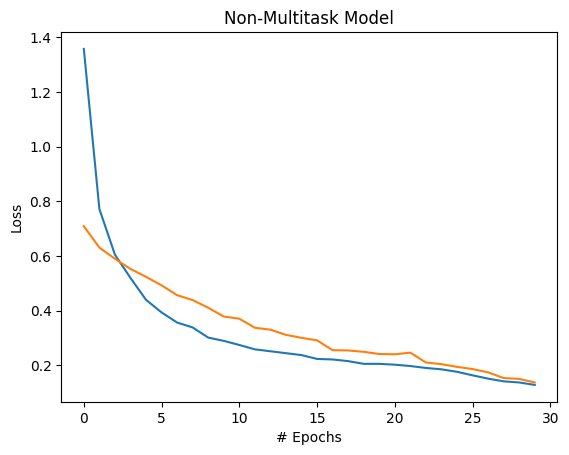

In [3]:
# example numbers
para = [0.709, 0.631, 0.590, 0.553, 0.524, 0.493, 0.457, 0.439, 0.411, 0.379, 0.371, 0.338, 0.331, 0.312, 0.301, 0.292, 0.256, 0.255, 0.250, 0.242, 0.241, 0.247, 0.211, 0.205, 0.195, 0.187, 0.175, 0.154, 0.151, 0.138]
sts = [1.357, 0.772, 0.605, 0.520, 0.440, 0.394, 0.357, 0.339, 0.302, 0.290, 0.275, 0.259, 0.252, 0.245, 0.238, 0.224, 0.222, 0.216, 0.206, 0.206, 0.203, 0.198, 0.191, 0.186, 0.177, 0.164, 0.152, 0.142, 0.138, 0.129]

plot_loss(sts, para, "Non-Multitask Model", "./plots/nonmultitask.png")